In [1]:
import pyspark
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
# plese type ur file location for filepath.

spark = SparkSession.builder.appName("bigdata")\
                    .config("spark.some.config.option", "some-value")\
                    .getOrCreate()

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # ignore warnings

In [24]:
%run data.py

In [100]:
# filter the dataframe, just leave the cases, deaths and ever-hospitalized
nycBorough = fetchData(nyc_his_boro_url)
borough = nycBorough[(nycBorough.type == "cases") | (nycBorough.type == "deaths") | (nycBorough.type == "ever-hospitalized")]
borough.head(10)

,timestamp,type,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
0,2020-03-12T04:00:00Z,cases,10,24,25,17,5,7,88
1,2020-03-13T04:00:00Z,cases,13,24,35,26,5,34,137
2,2020-03-15T04:00:00Z,cases,21,53,72,78,16,29,269
3,2020-03-16T04:00:00Z,cases,34,62,111,118,19,120,464
4,2020-03-17T22:00:00Z,cases,106,236,290,248,42,1,923
5,2020-03-18T21:30:00Z,cases,303,505,590,533,77,1,2009
6,2020-03-19T21:30:00Z,cases,496,1195,1038,1042,179,4,3954
7,2020-03-20T21:30:00Z,cases,736,1740,1402,1514,285,6,5683
8,2020-03-21T21:30:00Z,cases,1071,2484,1863,2254,437,6,8115
9,2020-03-22T13:54:00Z,deaths,14,14,10,21,4,0,63


In [101]:
# change the timestamp to date and rearrange the columns
borough[["date","time"]] = borough["timestamp"].str.split("T", expand = True)
borough = borough[["date","type","bronx","brooklyn","manhattan","queens","staten_island","unknown","total"]]
borough["date"] = pd.to_datetime(borough['date'])

In [102]:
borough.head(3)

,date,type,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
0,2020-03-12,cases,10,24,25,17,5,7,88
1,2020-03-13,cases,13,24,35,26,5,34,137
2,2020-03-15,cases,21,53,72,78,16,29,269


In [155]:
# save the first date and latest date 
firstRow = borough.head(1)
start_date = firstRow.iloc[[0],[0]].values[0][0]
start_date = pd.to_datetime(str(start_date)).strftime("%Y.%m.%d")

lastRow = borough.tail(1)
latest_date = lastRow.iloc[[0],[0]].values[0][0]
latest_date = pd.to_datetime(str(latest_date)).strftime("%Y.%m.%d")
print("First date: "+ start_date + "\tLatest date: " + latest_date)

First date: 2020.03.12	Latest date: 2020.05.04


In [99]:
# change the index from default to date
#boroughData = pd.DataFrame(borough)
#boroughData.set_index(["date"], inplace = True) 
#boroughData.head(10)

In [33]:
# get the latest data for condirmed cases, deaths and hospitalized
update = borough.tail(3)
update.set_index(["type"], inplace = True) 
update

,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
type,,,,,,,
cases,39239,45637,21287,53243,12235,82,171723
deaths,2997,4127,1797,4149,646,8,13724
ever-hospitalized,10084,11565,5869,13915,1931,19,43383


# NYC COVID-19 Summary

In [80]:
# data updated date
print("Update: " + latest_date + " (from 2020.03.12) ")

Update: 2020.05.04 (from 2020.03.12) 


In [35]:
# summary visulization
cm = sns.light_palette("#66cccc", as_cmap = True)
df1 = update.stack()
df2 = df1.unstack(0)
df2.style.background_gradient(cmap = cm)

type,cases,deaths,ever-hospitalized
bronx,39239,2997,10084
brooklyn,45637,4127,11565
manhattan,21287,1797,5869
queens,53243,4149,13915
staten_island,12235,646,1931
unknown,82,8,19
total,171723,13724,43383


In [ ]:
# Cases / Deaths / Hosplitalized Data for Each Borough

In [158]:
# regional all data generalize function
def regionData (regionSourceData, region):
    case = regionSourceData[(regionSourceData.type == "cases")]
    death = regionSourceData[(regionSourceData.type == "deaths")]
    hosp = regionSourceData[(regionSourceData.type == "ever-hospitalized")]
    
    case.rename(columns = {region:"cases"}, inplace = True)
    case.drop(columns = ["type"], inplace = True)
    
    death.rename(columns = {region:"deaths"}, inplace= True)
    death.drop(columns = ["type"], inplace = True)

    hosp.rename(columns = {region:"ever-hospitalized"}, inplace = True)
    hosp.drop(columns = ["type"], inplace = True)
    
    mergeHelper = pd.merge(case, hosp, how = "outer", on = ["date"])
    regionAllData = pd.merge(mergeHelper, death, how = "outer", on = ["date"])
    
    return regionAllData

In [163]:
# regional plot generalize function
def regionPlot (regionAllData, region):
    df = bronxAllData
    df["date"] = df["date"].astype(np.str_)
    df["date"] = pd.to_datetime(df["date"])
    df=df.set_index("date")

    df[["cases","ever-hospitalized","deaths"]].plot.area(stacked = False,cmap = "tab10_r")
    plt.title(region.capitalize() + " COVID-19 Data", fontsize = 20)
    plt.legend()
    plt.show()

# Data for Each Borough

In [169]:
# case, death, haspitalized data for bronx 
bronxData = borough[["date","type","bronx"]] 
region = "bronx"
bronxAllData = regionData (bronxData, region)
bronxAllData.head(5)

,date,cases,ever-hospitalized,deaths
0,2020-03-12,10,NaN,NaN
1,2020-03-13,13,NaN,NaN
2,2020-03-15,21,NaN,NaN
3,2020-03-16,34,NaN,NaN
4,2020-03-17,106,NaN,NaN


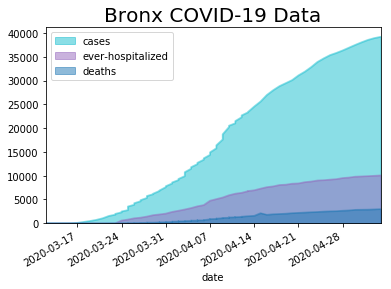

In [170]:
regionPlot (bronxAllData, region)

In [171]:
# case, death, haspitalized data for brooklyn
brooklynData = borough[["date","type","brooklyn"]] 
region = "brooklyn"
brooklynAllData = regionData (brooklynData, region)
brooklynAllData.head(5)

,date,cases,ever-hospitalized,deaths
0,2020-03-12,24,NaN,NaN
1,2020-03-13,24,NaN,NaN
2,2020-03-15,53,NaN,NaN
3,2020-03-16,62,NaN,NaN
4,2020-03-17,236,NaN,NaN


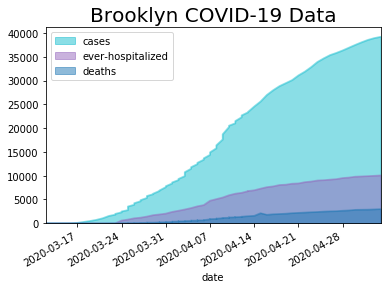

In [150]:
regionPlot (brooklynAllData, region)

In [172]:
# case, death, haspitalized data for manhattan
manhattanData = borough[["date","type","manhattan"]]
region = "manhattan"
manhattanAllData = regionData (manhattanData, region)
manhattanAllData.head(5)

,date,cases,ever-hospitalized,deaths
0,2020-03-12,25,NaN,NaN
1,2020-03-13,35,NaN,NaN
2,2020-03-15,72,NaN,NaN
3,2020-03-16,111,NaN,NaN
4,2020-03-17,290,NaN,NaN


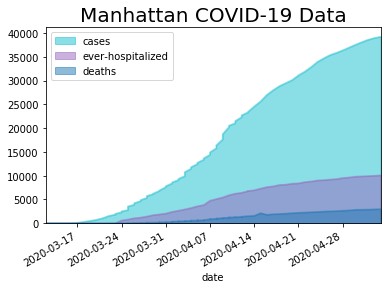

In [166]:
regionPlot (manhattanAllData, region)

In [173]:
# case, death, haspitalized data for queens
queensData = borough[["date","type","queens"]] 
region = "queens"
queensAllData = regionData (queensData, region)
queensAllData.head(5)

,date,cases,ever-hospitalized,deaths
0,2020-03-12,17,NaN,NaN
1,2020-03-13,26,NaN,NaN
2,2020-03-15,78,NaN,NaN
3,2020-03-16,118,NaN,NaN
4,2020-03-17,248,NaN,NaN


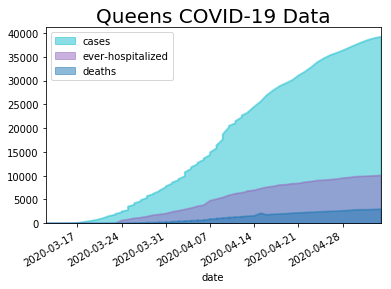

In [152]:
regionPlot (queensAllData, region)

In [174]:
# case, death, haspitalized data for staten_island
staten_islandData = borough[["date","type","staten_island"]] 
region = "staten_island"
staten_islandAllData = regionData (staten_islandData, region)
staten_islandAllData.head(5)

,date,cases,ever-hospitalized,deaths
0,2020-03-12,5,NaN,NaN
1,2020-03-13,5,NaN,NaN
2,2020-03-15,16,NaN,NaN
3,2020-03-16,19,NaN,NaN
4,2020-03-17,42,NaN,NaN


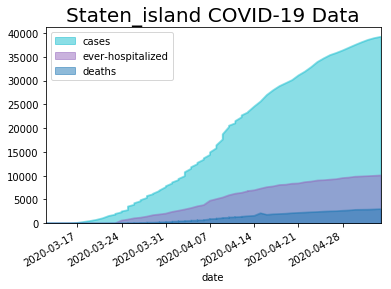

In [175]:
regionPlot (staten_islandAllData, region)